# Data Preprocessing

In [1]:
# Library imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [3]:
# Define paths
dataset_dir = 'Classification'  # Change this to your dataset path
leaf_dir = os.path.join(dataset_dir, 'leaf')
leaves_dir = os.path.join(dataset_dir, 'leaves')
processed_dir = os.path.join(dataset_dir, 'processed')

In [4]:
# Create processed directory if it doesn't exist
os.makedirs(os.path.join(processed_dir, 'train', 'leaf'), exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'train', 'leaves'), exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'val', 'leaf'), exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'val', 'leaves'), exist_ok=True)

Processing leaf: 3595 training images, 899 validation images
Processing leaves: 911 training images, 228 validation images
Found 4506 images belonging to 2 classes.
Found 1127 images belonging to 2 classes.
Data preprocessing complete!
Training samples: 4506
Validation samples: 1127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


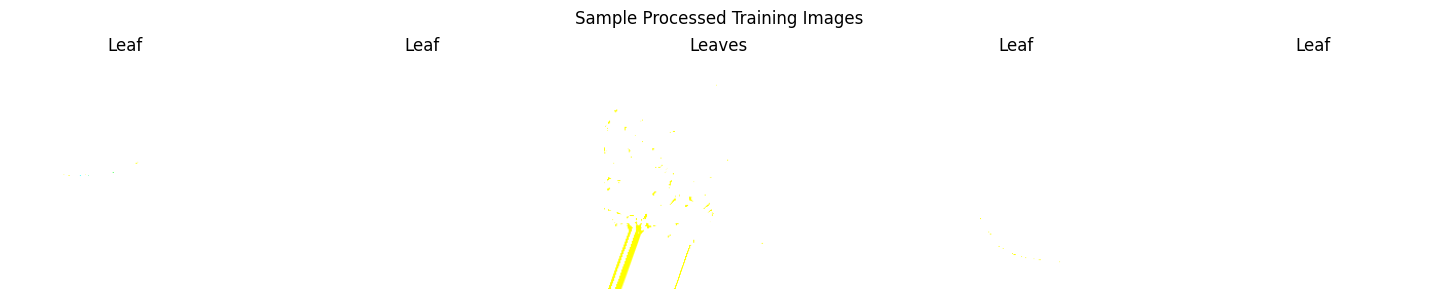

In [ ]:
# Image preprocessing parameters
img_size = (800, 800)  # Updated size for resizing images
batch_size = 32

# Function to preprocess images
def preprocess_image(img_path, target_size=img_size):
    # Read image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error reading image: {img_path}")
        return None
    
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize image
    img = cv2.resize(img, target_size)
    
    # Apply additional preprocessing as needed
    # Example: Contrast enhancement
    # img = cv2.convertScaleAbs(img, alpha=1.2, beta=10)
    
    # Normalize pixel values to [0,1]
    img = img / 255.0
    
    return img

# Function to split dataset into train and validation sets
def split_and_preprocess_dataset(class_dir, class_name, train_ratio=0.8):
    image_paths = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Split into train and validation
    train_paths, val_paths = train_test_split(image_paths, train_size=train_ratio, random_state=42)
    
    print(f"Processing {class_name}: {len(train_paths)} training images, {len(val_paths)} validation images")
    
    # Process and save training images
    for i, img_path in enumerate(train_paths):
        img = preprocess_image(img_path)
        if img is not None:
            output_path = os.path.join(processed_dir, 'train', class_name, f"{i}.jpg")
            plt.imsave(output_path, img)
    
    # Process and save validation images
    for i, img_path in enumerate(val_paths):
        img = preprocess_image(img_path)
        if img is not None:
            output_path = os.path.join(processed_dir, 'val', class_name, f"{i}.jpg")
            plt.imsave(output_path, img)

# Process both classes
split_and_preprocess_dataset(leaf_dir, 'leaf')
split_and_preprocess_dataset(leaves_dir, 'leaves')

# Create data generators for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(processed_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # binary classification: leaf vs leaves
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    os.path.join(processed_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Data preprocessing complete!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

# Visualize some processed images
def show_processed_samples(generator, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title)
    
    images, labels = next(generator)
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.title(f"{'Leaf' if labels[i] < 0.5 else 'Leaves'}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample processed images
show_processed_samples(train_generator, "Sample Processed Training Images")


# Train Model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [7]:
# Define paths and parameters
img_size = (128, 128)
batch_size = 32

In [9]:
# Train model to classify single leaf vs bunch of leaves
def train_leaf_classifier(train_dir, val_dir):
    # Data generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        classes=['leaf', 'leaves']  # Single leaf vs bunch of leaves
    )
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary',
        classes=['leaf', 'leaves']
    )
    
    # Build model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary: single leaf (0) vs bunch of leaves (1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
        ]
    )
    
    # Save the model
    model.save('leaf_classifier_model.h5')
    return model, history

In [ ]:
# Example usage
if __name__ == "__main__":
    # Train model
    print("Training leaf classifier model...")
    train_leaf_classifier('Classification/train', 'Classification/val')


Training leaf classifier model...
Found 4506 images belonging to 2 classes.
Found 1127 images belonging to 2 classes.
Epoch 1/15
141/141 [==============================] - 17s 116ms/step - loss: 0.1287 - accuracy: 0.9507 - val_loss: 0.0239 - val_accuracy: 0.9911
Epoch 2/15
141/141 [==============================] - 14s 101ms/step - loss: 0.0210 - accuracy: 0.9925 - val_loss: 0.0124 - val_accuracy: 0.9982
Epoch 3/15
141/141 [==============================] - 14s 98ms/step - loss: 0.0355 - accuracy: 0.9907 - val_loss: 0.0306 - val_accuracy: 0.9902
Epoch 4/15
141/141 [==============================] - 14s 101ms/step - loss: 0.0170 - accuracy: 0.9960 - val_loss: 0.0060 - val_accuracy: 0.9991
Epoch 5/15
141/141 [==============================] - 14s 99ms/step - loss: 0.0173 - accuracy: 0.9956 - val_loss: 0.0066 - val_accuracy: 0.9982
Epoch 6/15
141/141 [==============================] - 14s 102ms/step - loss: 0.0182 - accuracy: 0.9953 - val_loss: 0.0070 - val_accuracy: 0.9982
Epoch 7/15
141

## Testing

In [51]:
# Function to crop individual leaves from bunch images
def crop_individual_leaves(image_path, output_dir, base_filename):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return []
    
    # Create grayscale for processing without modifying original image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply threshold to create binary image
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area to remove noise
    min_contour_area = 1000  # Adjust based on your images
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    
    # Crop and save individual leaves
    cropped_paths = []
    for i, contour in enumerate(valid_contours):
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Add padding around the bounding box
        padding = 10
        x_start = max(0, x - padding)
        y_start = max(0, y - padding)
        x_end = min(image.shape[1], x + w + padding)
        y_end = min(image.shape[0], y + h + padding)
        
        # Crop the image (keeping original BGR format)
        cropped = image[y_start:y_end, x_start:x_end]
        
        # Skip if cropped image is too small
        if cropped.shape[0] < 20 or cropped.shape[1] < 20:
            continue
        
        # Make the cropped image square
        height, width, _ = cropped.shape
        max_dim = max(height, width)
        square_image = np.zeros((max_dim, max_dim, 3), dtype=np.uint8)  # Black background
        y_offset = (max_dim - height) // 2
        x_offset = (max_dim - width) // 2
        square_image[y_offset:y_offset + height, x_offset:x_offset + width] = cropped
        
        # Resize to 224x224
        resized_image = cv2.resize(square_image, (224, 224))
        
        # Save cropped image directly to output directory
        filename = f"{base_filename}_leaf_{i}.jpg"
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, resized_image)  # Save in original BGR format
        cropped_paths.append(output_path)
    
    return cropped_paths

# Main function to process a folder of images
def process_leaf_images(input_folder, output_folder):
    # Load trained model
    leaf_classifier = load_model('leaf_classifier_model.h5')
    
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    # Process each image in the input folder
    for filename in os.listdir(input_folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        image_path = os.path.join(input_folder, filename)
        base_filename = os.path.splitext(filename)[0]
        
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            continue
        
        # Create a copy for model input (needs RGB conversion for the model)
        img_for_model = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # For model input, resize to model's expected size
        img_size = (128, 128)  # Keep the model's expected input size
        img_resized = cv2.resize(img_for_model, img_size)
        img_array = np.expand_dims(img_resized / 255.0, axis=0)
        
        # Classify as single leaf or bunch of leaves
        bunch_prediction = leaf_classifier.predict(img_array)[0][0]
        
        if bunch_prediction < 0.5:  # Single leaf
            # Make the image square first (using original BGR image)
            height, width, _ = img.shape
            max_dim = max(height, width)
            square_image = np.zeros((max_dim, max_dim, 3), dtype=np.uint8)  # Black background
            y_offset = (max_dim - height) // 2
            x_offset = (max_dim - width) // 2
            square_image[y_offset:y_offset + height, x_offset:x_offset + width] = img
            
            # Resize to 224x224
            output_image = cv2.resize(square_image, (224, 224))
            
            # Save single leaf image directly to output folder
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, output_image)  # Save in original BGR format
        else:  # Bunch of leaves
            # Crop individual leaves and save directly to output folder
            crop_individual_leaves(image_path, output_folder, base_filename)
    
    print("Processing complete!")


In [54]:
print("Processing images...")
process_leaf_images('Classification/test', 'Classification/processed')

Processing images...
1/1 [==============================] - 0s 36ms/step
Processing complete!
